# Shade-Optimized Pedestrian Routing to Transit
## University City, Philadelphia

**Author:** Kavana Raju  
**Course:** MUSA 5500 - Geospatial Data Science with Python  

### Project Overview
This analysis develops a shade-optimized pedestrian routing system for University City, Philadelphia. The project aims to identify shadier walking routes to transit stops using tree canopy coverage and building shadow analysis.

**Key Research Questions:**
1. What is the distribution of shade coverage along pedestrian routes to transit in University City?
2. How much longer are shadier routes compared to shortest-distance routes?

**Data Sources:**
- OpenStreetMap pedestrian network (via OSMnx)
- Philadelphia 2018 High-Resolution Land Cover (PASDA)
- OpenDataPhilly building footprints
- SEPTA Spring 2025 transit stops (official GTFS)

## Notebook 1: Data Acquisition
This notebook downloads and prepares all spatial datasets needed for shade routing analysis.

### Setup and Imports
Import key libraries for analysis.

In [4]:
# Standard libraries
import os
import json
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Geospatial analysis
import geopandas as gpd
from shapely.geometry import Point, box
import osmnx as ox

# Raster analysis
import rasterio
from rasterio.mask import mask
from rasterio.plot import show

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

# Configure plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


### Create Project Directory Structure
Organize data into raw/processed folders.

In [5]:
# Create directory structure
directories = [
    'data/raw',
    'data/processed', 
    'outputs/maps',
    'outputs/figures'
]

for directory in directories:
    Path(directory).mkdir(parents=True, exist_ok=True)
    
print("✓ Project directories created")
print("  • data/raw - Original downloaded data")
print("  • data/processed - Cleaned and filtered data")
print("  • outputs/maps - Cartographic visualizations")
print("  • outputs/figures - Analysis plots")

✓ Project directories created
  • data/raw - Original downloaded data
  • data/processed - Cleaned and filtered data
  • outputs/maps - Cartographic visualizations
  • outputs/figures - Analysis plots


## Part 1: Define Study Area
University City is defined using a bounding box since OSM does not have a formal neighborhood polygon.

In [6]:
# Define University City bounding box
# Coordinates chosen to capture Penn, Drexel, and surrounding neighborhoods
west, south = -75.230, 39.945
east, north = -75.180, 39.965

# Create study area polygon
study_area = gpd.GeoDataFrame(
    {'name': ['University City Study Area']},
    geometry=[box(west, south, east, north)],
    crs='EPSG:4326'  # WGS84
)

# Save for future use
study_area.to_file('data/processed/study_area.geojson', driver='GeoJSON')

# Calculate area
# Project to PA State Plane South (EPSG:2272) for accurate area calculation
study_area_proj = study_area.to_crs('EPSG:2272')
area_sqft = study_area_proj.geometry.area.iloc[0]
area_sqmi = area_sqft / (5280 ** 2)  # Convert sq ft to sq mi

print(f"✓ Study area defined: University City, Philadelphia")
print(f"  Bounds: {west:.3f}°W to {east:.3f}°W, {south:.3f}°N to {north:.3f}°N")
print(f"  Area: {area_sqmi:.2f} square miles")

✓ Study area defined: University City, Philadelphia
  Bounds: -75.230°W to -75.180°W, 39.945°N to 39.965°N
  Area: 3.66 square miles


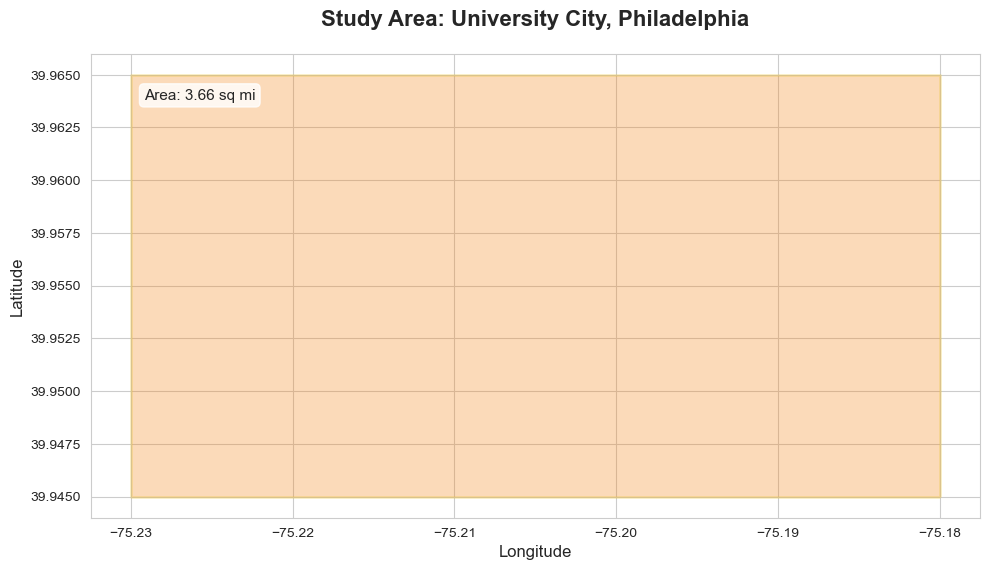

In [7]:
## Visualize study area
fig, ax = plt.subplots(figsize=(10, 10))

study_area.plot(
    ax=ax,
    facecolor='#f58518',
    edgecolor='#eeca3b',
    linewidth=2,
    alpha=0.3
)

ax.set_title('Study Area: University City, Philadelphia', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Add extent annotation
ax.text(0.06, 0.925, f'Area: {area_sqmi:.2f} sq mi',
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('outputs/maps/01_study_area.png', dpi=300, bbox_inches='tight') #save map
plt.show()

## Part 2: Download Pedestrian Network
Using OSMnx to download the walking network from OpenStreetMap.

In [8]:
# Download pedestrian network using OSMnx

# Get walking network for study area
G = ox.graph_from_polygon(
    study_area.geometry.iloc[0],
    network_type='walk',  # Pedestrian paths, sidewalks, crosswalks
    simplify=True,  # Remove unnecessary nodes
    retain_all=False  # Remove disconnected components
)

# Network statistics
n_nodes = len(G.nodes())
n_edges = len(G.edges())

print(f"✓ Network downloaded successfully")
print(f"  Nodes (intersections): {n_nodes:,}")
print(f"  Edges (street segments): {n_edges:,}")

# Save network in GraphML format (preserves all attributes)
ox.save_graphml(G, 'data/processed/university_city_walk_network.graphml')

✓ Network downloaded successfully
  Nodes (intersections): 7,343
  Edges (street segments): 23,486


In [9]:
# Convert network to GeoDataFrames for easier analysis

# Extract nodes (intersections)
nodes_gdf = ox.graph_to_gdfs(G, edges=False, nodes=True).reset_index()

# Extract edges (street segments)
edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index()

# Handle list columns for GeoJSON compatibility
# Some OSM attributes are stored as lists, which GeoJSON doesn't support
for col in edges_gdf.columns:
    if edges_gdf[col].apply(lambda x: isinstance(x, list)).any():
        edges_gdf[col] = edges_gdf[col].apply(
            lambda x: ','.join(map(str, x)) if isinstance(x, list) else x
        )

# Save as GeoJSON for compatibility with other tools
nodes_gdf.to_file('data/processed/network_nodes.geojson', driver='GeoJSON')
edges_gdf.to_file('data/processed/network_edges.geojson', driver='GeoJSON')

print(f"Nodes GeoDataFrame: {len(nodes_gdf):,} features")
print(f"  Columns: {', '.join(list(nodes_gdf.columns[:10]))}")
print(f"\nEdges GeoDataFrame: {len(edges_gdf):,} features")
print(f"  Columns: {', '.join(list(edges_gdf.columns[:10]))}")

Nodes GeoDataFrame: 7,343 features
  Columns: osmid, y, x, street_count, highway, geometry

Edges GeoDataFrame: 23,486 features
  Columns: u, v, key, osmid, name, highway, oneway, reversed, length, geometry


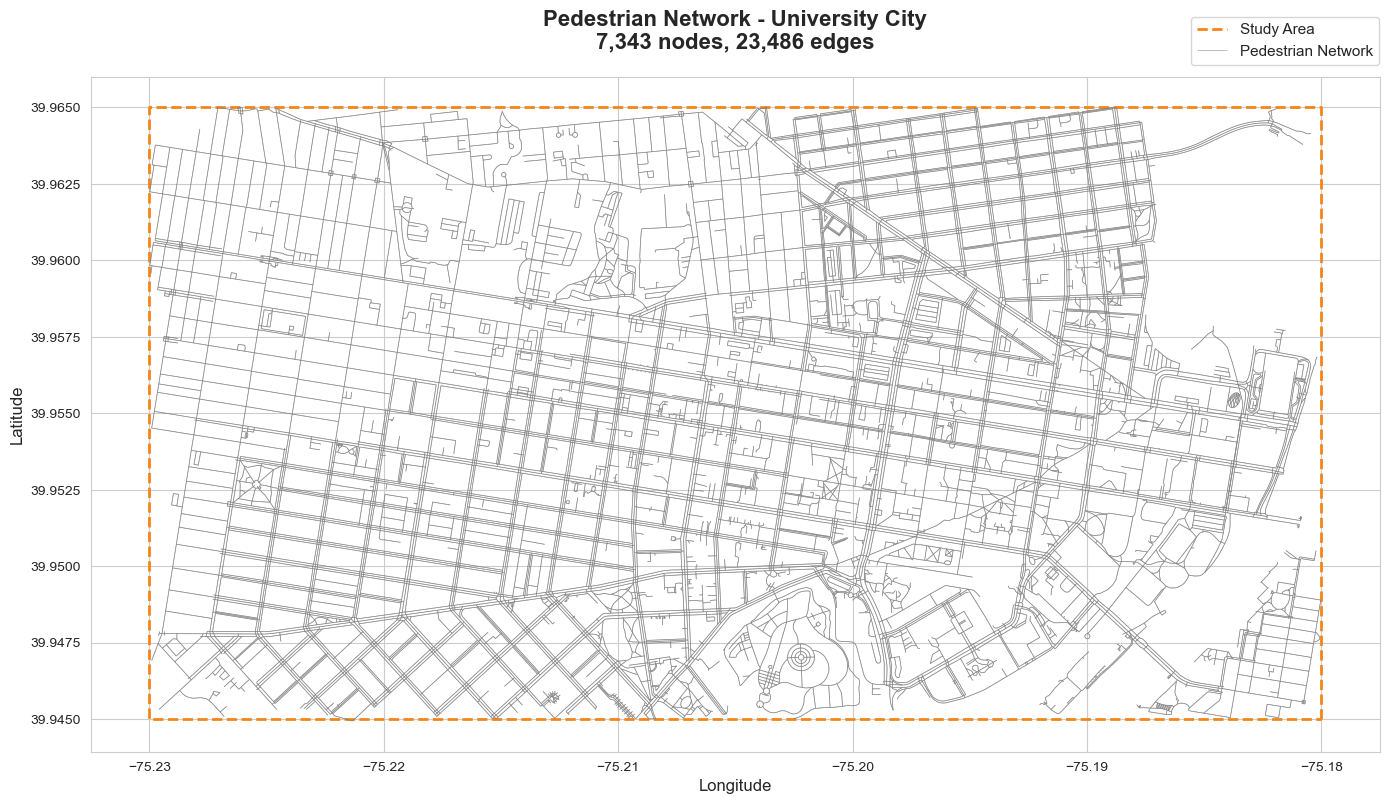

In [10]:
# Visualize the pedestrian network
fig, ax = plt.subplots(figsize=(14, 14))

# Plot study area boundary
study_area.boundary.plot(
    ax=ax,
    color='#f58518',
    linewidth=2,
    linestyle='--',
    label='Study Area'
)

# Plot street network
edges_gdf.plot(
    ax=ax,
    linewidth=0.5,
    color='gray',
    alpha=0.7,
    label='Pedestrian Network'
)

ax.set_title('Pedestrian Network - University City\n' + 
             f'{n_nodes:,} nodes, {n_edges:,} edges',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(fontsize=11, loc='upper right',bbox_to_anchor=(1.005, 1.1))

plt.tight_layout()
plt.savefig('outputs/maps/02_network.png', dpi=300, bbox_inches='tight')
plt.show()

## Part 3: Get SEPTA Transit Stops
Loading official SEPTA transit stops from Spring 2025 GTFS data. I focus on major transit stations plus connecting bus stops to analyze first/last mile walkability.

In [19]:
# Check the types of ways in your network
highway_types = {}
for u, v, key, data in G.edges(keys=True, data=True):
    highway = data.get('highway', 'unknown')
    if isinstance(highway, list):
        highway = highway[0]
    highway_types[highway] = highway_types.get(highway, 0) + 1

print("Edge types in your network:")
for highway, count in sorted(highway_types.items(), key=lambda x: x[1], reverse=True):
    pct = count / len(G.edges()) * 100
    print(f"  {highway:20s}: {count:5,} edges ({pct:5.1f}%)")

Edge types in your network:
  footway             : 13,218 edges ( 56.3%)
  residential         : 3,916 edges ( 16.7%)
  service             : 3,238 edges ( 13.8%)
  primary             : 1,382 edges (  5.9%)
  secondary           :   650 edges (  2.8%)
  tertiary            :   622 edges (  2.6%)
  pedestrian          :   282 edges (  1.2%)
  path                :    96 edges (  0.4%)
  steps               :    52 edges (  0.2%)
  primary_link        :    22 edges (  0.1%)
  unclassified        :     6 edges (  0.0%)
  secondary_link      :     2 edges (  0.0%)


In [11]:
# Load official SEPTA GeoJSON

# Read all SEPTA stops (system-wide)
septa_all = gpd.read_file('data/raw/Transit_Stops_(Spring_2025).geojson')

print(f"✓ Loaded {len(septa_all):,} SEPTA stops (system-wide)")
print(f"  Columns: {list(septa_all.columns)}")

✓ Loaded 22,478 SEPTA stops (system-wide)
  Columns: ['FID', 'LineAbbr', 'Direction', 'Sequence', 'StopId', 'StopAbbr', 'StopName', 'Lon', 'Lat', 'geometry']


In [12]:
# Filter to University City study area
septa_in_area = gpd.sjoin(
    septa_all,
    study_area,
    how='inner',
    predicate='intersects'
)

# Remove duplicates (same stop may appear for multiple routes)
septa_in_area = septa_in_area.drop_duplicates(subset=['StopId'])

# Clean up columns
if 'index_right' in septa_in_area.columns:
    septa_in_area = septa_in_area.drop(columns=['index_right'])

print(f"\n✓ Filtered to {len(septa_in_area)} stops in University City")


✓ Filtered to 424 stops in University City


In [13]:
# Categorize stops by transit mode
# SEPTA uses specific line abbreviations for different modes

def categorize_septa_stop(line_abbr):
    line = str(line_abbr).upper()
    
    # Regional Rail lines
    rail_lines = ['AIR', 'CHE', 'CHW', 'CYN', 'FOX', 'LAN', 'MED', 'NOR', 
                  'PAO', 'TRE', 'WAR', 'WIL', 'WTR']
    
    # Subway lines (Market-Frankford, Broad Street)
    subway_lines = ['MFL', 'BSL', 'BSS', 'NHSL']
    
    # Trolley/Light Rail lines
    trolley_lines = ['10', '11', '13', '34', '36', '101', '102', 'GRHL']
    
    if line in rail_lines:
        return 'Regional Rail'
    elif line in subway_lines:
        return 'Subway'
    elif line in trolley_lines:
        return 'Trolley'
    else:
        return 'Bus'

# Apply categorization
septa_in_area['transit_type'] = septa_in_area['LineAbbr'].apply(categorize_septa_stop)

# Show breakdown
print("\nStops by transit mode:")
for mode, count in septa_in_area['transit_type'].value_counts().items():
    print(f"  {mode}: {count}")


Stops by transit mode:
  Bus: 414
  Subway: 10


In [14]:
# Select major transit stations (Subway - Market-Frankford Line)
# These are high-capacity stations serving as primary destinations

major_transit = septa_in_area[septa_in_area['transit_type'] == 'Subway'].copy()

# Get unique station locations (remove duplicate directions)
major_stations_unique = major_transit.groupby('StopName').first().reset_index()
major_stations_gdf = gpd.GeoDataFrame(
    major_stations_unique,
    geometry=major_stations_unique['geometry'],
    crs=septa_in_area.crs
)

print(f"\nMajor transit stations (Subway): {len(major_stations_gdf)}")
for idx, row in major_stations_gdf.iterrows():
    print(f"  • {row['StopName']}")


Major transit stations (Subway): 5
  • 34th St
  • 40th St
  • 46th St
  • 52nd St
  • Drexel Station at 30th S


In [15]:
# Add connecting bus stops for transit connectivity analysis
# This analyzes "last mile" walkability from bus stops to subway stations

print("\nFinding connecting bus stops...\n")

n_bus_stops = 10  # Number of nearest bus stops per major station

bus_stops = septa_in_area[septa_in_area['transit_type'] == 'Bus'].copy()

# Project to PA State Plane for accurate distance calculations
major_proj = major_stations_gdf.to_crs('EPSG:2272')
bus_proj = bus_stops.to_crs('EPSG:2272')

# Find nearest bus stops to each major station
selected_bus_stops = []

for idx, station in major_proj.iterrows():
    # Calculate distances from this station to all bus stops
    bus_proj['distance'] = bus_proj.geometry.distance(station.geometry)
    
    # Get N nearest bus stops
    nearest = bus_proj.nsmallest(n_bus_stops, 'distance').copy()
    nearest['connects_to'] = station['StopName']
    
    selected_bus_stops.append(nearest)
    
    # Show results for this station
    print(f"{station['StopName']}:")
    print(f"  {len(nearest)} nearest bus stops within {nearest['distance'].max() * 0.3048:.0f}m")

# Combine all selected bus stops
all_selected_bus = pd.concat(selected_bus_stops, ignore_index=True)

# Remove duplicates (bus stop may be near multiple stations)
unique_bus_stops = all_selected_bus.drop_duplicates(subset=['StopId']).to_crs('EPSG:4326')

print(f"\n✓ Selected {len(unique_bus_stops)} unique connecting bus stops")


Finding connecting bus stops...

34th St:
  10 nearest bus stops within 200m
40th St:
  10 nearest bus stops within 261m
46th St:
  10 nearest bus stops within 173m
52nd St:
  10 nearest bus stops within 181m
Drexel Station at 30th S:
  10 nearest bus stops within 177m

✓ Selected 50 unique connecting bus stops


In [16]:
# Combine major transit + bus stops into final dataset
major_transit['stop_category'] = 'Major Transit'
unique_bus_stops['stop_category'] = 'Feeder Bus'

# Standardize columns
cols_common = ['StopId', 'StopName', 'LineAbbr', 'transit_type', 
               'stop_category', 'geometry']

final_stops = pd.concat([
    major_transit[cols_common],
    unique_bus_stops[cols_common]
], ignore_index=True)

# Rename for clarity
final_stops = final_stops.rename(columns={
    'StopName': 'name',
    'transit_type': 'type',
    'stop_category': 'category'
})

# Save final dataset
final_stops.to_file('data/processed/septa_stops.geojson', driver='GeoJSON')
septa_gdf = final_stops.copy()

print(f"\nFinal transit stops dataset: {len(final_stops)}")
print(f"  • Major transit: {len(final_stops[final_stops['category'] == 'Major Transit'])}")
print(f"  • Connecting bus: {len(final_stops[final_stops['category'] == 'Feeder Bus'])}")


Final transit stops dataset: 60
  • Major transit: 10
  • Connecting bus: 50


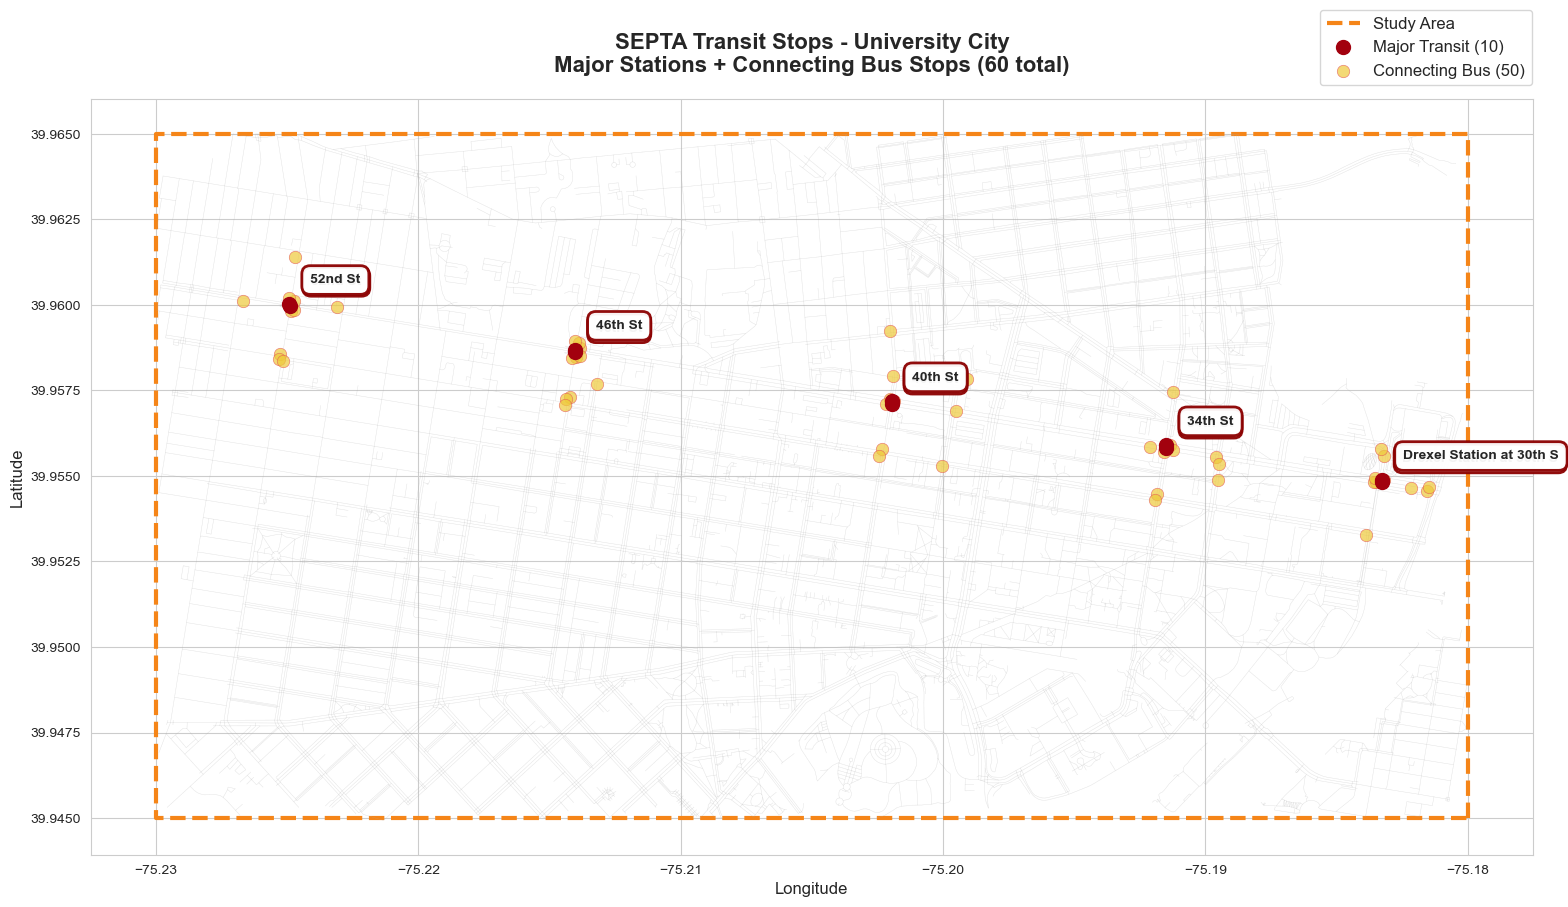

In [17]:
# Visualize transit connectivity
fig, ax = plt.subplots(figsize=(16, 14))

# Study area and network (background)
study_area.boundary.plot(
    ax=ax, color='#f58518', linewidth=3, 
    linestyle='--', label='Study Area', zorder=1
)
edges_gdf.plot(
    ax=ax, color='#B0B0B0', linewidth=0.3, 
    alpha=0.2, zorder=2
)

# Major transit stations (prominent)
major_plot = final_stops[final_stops['category'] == 'Major Transit']
major_plot.plot(
    ax=ax, color='#A2010E', markersize=100, 
    marker='o',
    label=f'Major Transit ({len(major_plot)})', 
    zorder=10
)

# Connecting bus stops (smaller)
bus_plot = final_stops[final_stops['category'] == 'Feeder Bus']
bus_plot.plot(
    ax=ax, color='#eeca3b', markersize=80, 
    marker='o', edgecolor='#e45756', linewidth=0.5,
    label=f'Connecting Bus ({len(bus_plot)})', 
    alpha=0.7, zorder=9
)

# Add labels for major stations
for idx, row in major_plot.iterrows():
    ax.annotate(
        row['name'],
        xy=(row.geometry.x, row.geometry.y),
        xytext=(15, 15),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold',
        bbox=dict(
            boxstyle='round,pad=0.6', 
            facecolor='white',
            edgecolor='darkred', 
            linewidth=2, 
            alpha=0.95
        ),
        zorder=11
    )

ax.set_title(
    'SEPTA Transit Stops - University City\n' + 
    f'Major Stations + Connecting Bus Stops ({len(final_stops)} total)',
    fontsize=16, fontweight='bold', pad=20
)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1.005, 1.13))

plt.tight_layout()
plt.savefig('outputs/maps/03_septa_stops.png', dpi=300, bbox_inches='tight')
plt.show()

## Part 4: Download Building Footprints
Building footprints from OpenDataPhilly will be used to estimate building shadows.

In [20]:
# Download building footprints from OpenDataPhilly

# OpenDataPhilly building footprints API
buildings_url = "https://hub.arcgis.com/api/v3/datasets/ab9e89e1273f445bb265846c90b38a96_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"

# Read buildings for entire city
buildings = gpd.read_file(buildings_url)

print(f"✓ Downloaded {len(buildings):,} building footprints (city-wide)")
print(f"  Columns: {list(buildings.columns)}")

✓ Downloaded 545,917 building footprints (city-wide)
  Columns: ['objectid', 'bin', 'fcode', 'address', 'building_name', 'base_elevation', 'approx_hgt', 'max_hgt', 'parcel_id_num', 'parcel_id_source', 'dor_alternate_addr', 'square_ft', 'Shape__Area', 'Shape__Length', 'geometry']


In [21]:
# Filter buildings to study area
buildings_filtered = gpd.sjoin(
    buildings,
    study_area,
    how='inner',
    predicate='intersects'
)

# Remove duplicates
buildings_filtered = buildings_filtered.drop_duplicates(subset=['geometry'])

if 'index_right' in buildings_filtered.columns:
    buildings_filtered = buildings_filtered.drop(columns=['index_right'])

print(f"\n✓ Filtered to {len(buildings_filtered):,} buildings in University City")

# Check for height/elevation attributes (needed for shadow calculation)
height_cols = [col for col in buildings_filtered.columns 
               if any(x in col.lower() for x in ['height', 'elevation', 'stories'])]

if height_cols:
    print(f"  Height columns available: {height_cols}")
else:
    print("  ⚠ No height/elevation columns found")
    print("  Shadow analysis will use footprint area as proxy")

# Save filtered buildings
buildings_filtered.to_file(
    'data/processed/buildings_university_city.geojson',
    driver='GeoJSON'
)


✓ Filtered to 16,635 buildings in University City
  Height columns available: ['base_elevation']


In [30]:
print("\nAll columns in buildings data:")
for col in buildings.columns:
    if col != 'geometry':
        print(f"  - {col}")

# Check specifically for these
height_related = ['height', 'building:height', 'building:levels', 
                 'levels', 'roof:height', 'est_height']

print("\nChecking for actual height columns:")
for col in height_related:
    if col in buildings.columns:
        non_null = buildings[col].notna().sum()
        print(f"  ✓ {col}: {non_null}/{len(buildings)} ({non_null/len(buildings)*100:.1f}%)")
    else:
        print(f"  ✗ {col}: not found")


All columns in buildings data:
  - objectid
  - bin
  - fcode
  - address
  - building_name
  - base_elevation
  - approx_hgt
  - max_hgt
  - parcel_id_num
  - parcel_id_source
  - dor_alternate_addr
  - square_ft
  - Shape__Area
  - Shape__Length

Checking for actual height columns:
  ✗ height: not found
  ✗ building:height: not found
  ✗ building:levels: not found
  ✗ levels: not found
  ✗ roof:height: not found
  ✗ est_height: not found


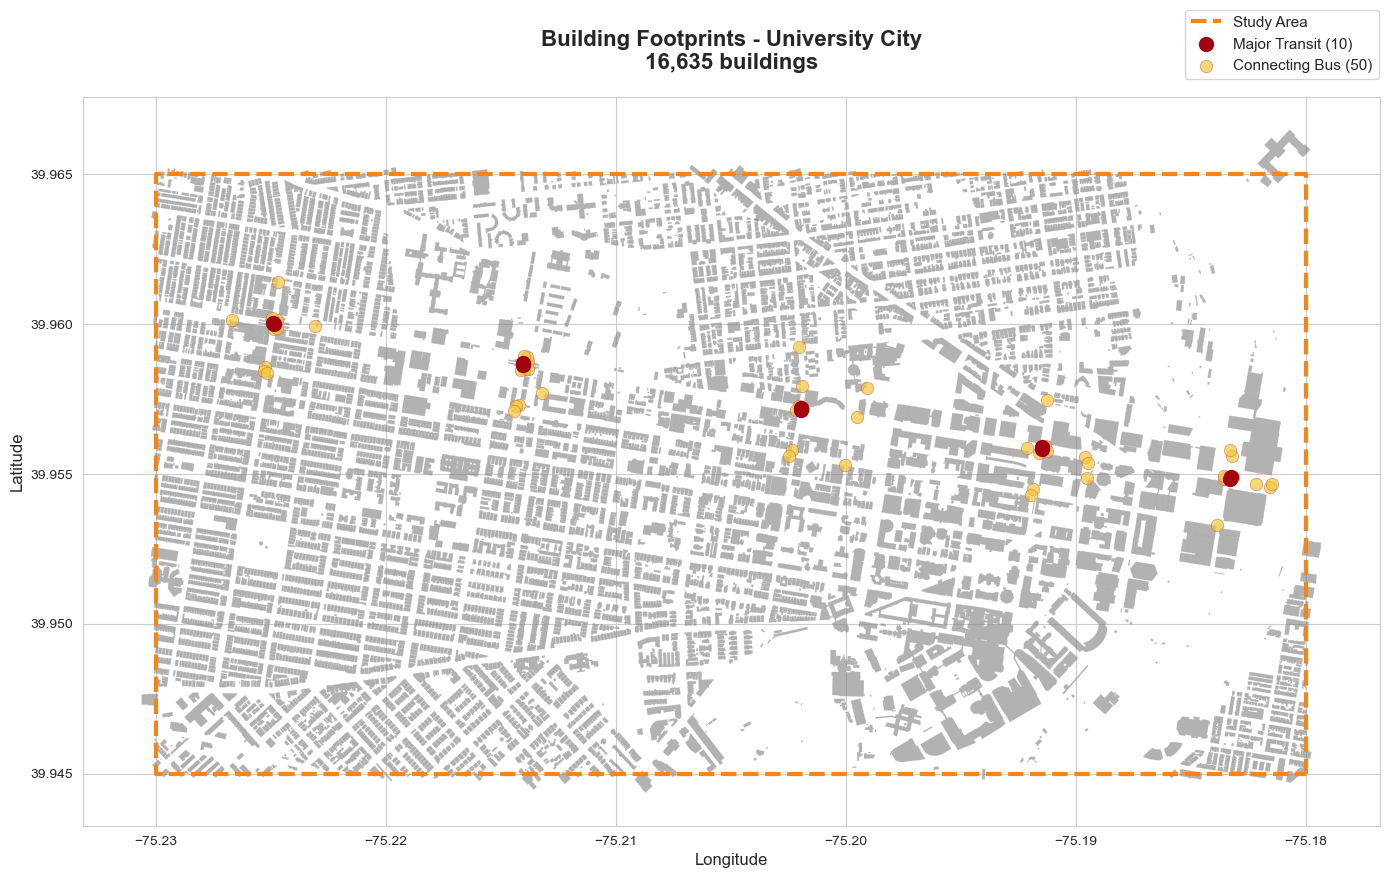

In [22]:
# Visualize building footprints
fig, ax = plt.subplots(figsize=(14, 14))

# Study area boundary
study_area.boundary.plot(
    ax=ax, color='#f58518', linewidth=3,
    linestyle='--', label='Study Area'
)

# Building footprints
buildings_filtered.plot(
    ax=ax,
    facecolor='gray',
    edgecolor='darkgray',
    linewidth=0.3,
    alpha=0.6,
    label=f'Buildings ({len(buildings_filtered):,})'
)

# SEPTA stops overlay
# Major transit stations (prominent)
major_plot.plot(
    ax=ax, color='#A2010E', markersize=100, 
    marker='o',
    label=f'Major Transit ({len(major_plot)})', 
    zorder=10
)

# Connecting bus stops (smaller)
bus_plot.plot(
    ax=ax, color='#eeca3b', markersize=80, 
    marker='o', edgecolor='#e45756', linewidth=0.5,
    label=f'Connecting Bus ({len(bus_plot)})', 
    alpha=0.7, zorder=9
)

ax.set_title(
    f'Building Footprints - University City\n{len(buildings_filtered):,} buildings',
    fontsize=16, fontweight='bold', pad=20
)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(fontsize=11, loc='upper right', bbox_to_anchor=(1.005, 1.13))

plt.tight_layout()
plt.savefig('outputs/maps/04_buildings.png', dpi=300, bbox_inches='tight')
plt.show()

## Part 5: Download and Process Tree Canopy Data
Using Philadelphia's 2018 High-Resolution Land Cover dataset from PASDA. This raster classifies land cover at 0.5m resolution based on LiDAR and aerial imagery.

In [23]:
# Load the Philadelphia Land Cover geodatabase
# Source: https://www.pasda.psu.edu/uci/DataSummary.aspx?dataset=1587
gdb_path = 'data/raw/PPR_LandCover_2018.gdb'

# Open the raster from geodatabase
with rasterio.open(gdb_path) as src:
    print(f"✓ Opened Land Cover raster")
    print(f"  Dimensions: {src.width:,} x {src.height:,} pixels")
    print(f"  Resolution: {src.res[0]:.2f} x {src.res[1]:.2f} meters")
    print(f"  CRS: {src.crs}")

✓ Opened Land Cover raster
  Dimensions: 216,480 x 242,880 pixels
  Resolution: 0.50 x 0.50 meters
  CRS: EPSG:2272


In [24]:
# Clip raster to University City study area

with rasterio.open(gdb_path) as src:
    
    # Reproject study area to match raster CRS
    study_area_reproj = study_area.to_crs(src.crs)
    
    # Clip raster to study area
    out_image, out_transform = mask(
        src,
        study_area_reproj.geometry,
        crop=True,
        all_touched=True,
        filled=True,
        nodata=0
    )
    
    # Update metadata for output
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "compress": "lzw"
    })
    
    # Save clipped raster
    clipped_path = 'data/raw/landcover_university_city.tif'
    
    with rasterio.open(clipped_path, "w", **out_meta) as dest:
        dest.write(out_image)
    
    print(f"✓ Clipped raster saved")
    print(f"  Size: {out_image.shape[2]:,} x {out_image.shape[1]:,} pixels")

✓ Clipped raster saved
  Size: 28,444 x 15,374 pixels


In [25]:
# Analyze land cover classes
# Classes: 1=Tree Canopy, 2=Grass/Shrub, 3=Bare Earth, 4=Water, 5=Buildings, 6=Roads, 7=Other Paved

with rasterio.open(clipped_path) as src:
    landcover = src.read(1)
    
    # Get unique values
    unique_vals = np.unique(landcover)
    
    print("\nLand cover classes in University City:")
    print(f"  Values present: {unique_vals}")
    
    # Count pixels per class
    class_names = {
        0: 'NoData',
        1: 'Tree Canopy',
        2: 'Grass/Shrub',
        3: 'Bare Earth',
        4: 'Water',
        5: 'Buildings',
        6: 'Roads',
        7: 'Other Paved'
    }
    
    print("\nPixel counts by class:")
    for val in unique_vals:
        count = np.sum(landcover == val)
        percent = (count / landcover.size) * 100
        class_name = class_names.get(val, f'Unknown ({val})')
        print(f"  {class_name:.<30} {count:>12,} pixels ({percent:>5.1f}%)")


Land cover classes in University City:
  Values present: [0 1 2 3 4 5 6 7]

Pixel counts by class:
  NoData........................   28,754,312 pixels (  6.6%)
  Tree Canopy...................   59,301,698 pixels ( 13.6%)
  Grass/Shrub...................   61,184,028 pixels ( 14.0%)
  Bare Earth....................    7,501,177 pixels (  1.7%)
  Water.........................    8,724,190 pixels (  2.0%)
  Buildings.....................  120,043,222 pixels ( 27.5%)
  Roads.........................   69,606,855 pixels ( 15.9%)
  Other Paved...................   82,182,574 pixels ( 18.8%)


In [37]:
# Extract tree canopy (class 1) as separate layer

with rasterio.open(clipped_path) as src:
    landcover = src.read(1)
    
    # Create binary tree canopy mask
    tree_canopy_mask = (landcover == 1).astype(np.uint8)
    
    # Calculate statistics
    total_pixels = landcover.size
    tree_pixels = np.sum(tree_canopy_mask)
    tree_percent = (tree_pixels / total_pixels) * 100
    
    # Calculate area (0.5m x 0.5m pixels)
    pixel_area = 0.5 * 0.5  # square meters
    tree_area_sqm = tree_pixels * pixel_area
    tree_area_acres = tree_area_sqm * 0.000247105
    tree_area_sqkm = tree_area_sqm / 1_000_000
    
    print(f"Tree Canopy Coverage:")
    print(f"  Pixels: {tree_pixels:,} / {total_pixels:,}")
    print(f"  Percentage: {tree_percent:.1f}%")
    print(f"  Area: {tree_area_sqm:,.0f} sq meters")
    print(f"        {tree_area_acres:.1f} acres")
    print(f"        {tree_area_sqkm:.2f} sq km")
    
    # Save tree canopy as separate raster
    tree_raster_path = 'data/processed/tree_canopy_university_city.tif'
    
    meta = src.meta.copy()
    meta.update({
        'dtype': 'uint8',
        'nodata': 0,
        'compress': 'lzw'
    })
    
    with rasterio.open(tree_raster_path, 'w', **meta) as dst:
        dst.write(tree_canopy_mask, 1)

Tree Canopy Coverage:
  Pixels: 59,301,698 / 437,298,056
  Percentage: 13.6%
  Area: 14,825,424 sq meters
        3663.4 acres
        14.83 sq km


In [ ]:
# Visualize land cover and tree canopy
with rasterio.open(clipped_path) as src:
    landcover = src.read(1)
    tree_canopy_mask = (landcover == 1).astype(np.uint8)

     # Use the raster’s spatial extent for both plots (tilt mismatch)
    extent = [
        src.bounds.left,
        src.bounds.right,
        src.bounds.bottom,
        src.bounds.top
    ]
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot 1: Full land cover
    ax1 = axes[0]
    
    # Define colors for each class
    colors = {
        0: '#f0f0f0',  # NoData - light gray
        1: '#54a24b',  # Tree canopy - green
        2: '##c0d77c',  # Grass/shrub - light green
        3: 'e4d6c6',  # Bare earth - light brown
        4: '#83a8b1',  # Water - blue
        5: '#707070',  # Buildings - dark grey
        6: '#b0b0b0',  # Roads - dim gray
        7: '#f0f0f0'   # Other paved - light gray
    }
    
    # Create colored RGB image
    colored = np.zeros((*landcover.shape, 3), dtype=np.uint8)
    for val, color in colors.items():
        mask_val = (landcover == val)
        rgb = tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        colored[mask_val] = rgb
    
    ax1.imshow(colored, extent=extent, origin='upper')
    ax1.set_title(
        'Philadelphia Land Cover - University City\n(2018 High Resolution - 0.5m)',
        fontsize=14, fontweight='bold'
    )
    ax1.axis('off')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#54a24b', label=f'Tree Canopy ({tree_percent:.1f}%)'),
        Patch(facecolor='#c0d77c', label='Grass/Shrub'),
        Patch(facecolor='#e4d6c6', label='Bare Earth'),
        Patch(facecolor='#83a8b1', label='Water'),
        Patch(facecolor='#707070', label='Buildings'),
        Patch(facecolor='#b0b0b0', label='Roads'),
        Patch(facecolor='#f0f0f0', label='Other Paved')
    ]
    ax1.legend(
        handles=legend_elements,
        loc='upper right',
        fontsize=10,
        framealpha=0.9,
        edgecolor='black'
    )

    #custom green gradient
    colors = ['#c0d77c', '#54a24b', '#c0d77c']  # Light → Medium → Dark green
    n_bins = 100  # Smooth gradient
    custom_greens = LinearSegmentedColormap.from_list('custom_greens', colors, N=n_bins)
    
    # Plot 2: Tree canopy only
    ax2 = axes[1]
    
    tree_display = np.ma.masked_where(tree_canopy_mask == 0, tree_canopy_mask)
    
    ax2.imshow(np.ones_like(landcover) * 0.95, cmap='gray', vmin=0, vmax=1,extent=extent,
        origin='upper')
    ax2.imshow(tree_display, cmap=custom_greens, alpha=0.9, vmin=0, vmax=1,extent=extent,
        origin='upper')
    ax2.set_title(
        f'Tree Canopy Coverage\n{tree_percent:.1f}% ({tree_area_acres:.1f} acres)',
        fontsize=14, fontweight='bold'
    )
    ax2.axis('off')
    
    plt.tight_layout()
    plt.savefig('outputs/maps/05_tree_canopy.png', dpi=300, bbox_inches='tight')
    plt.show()

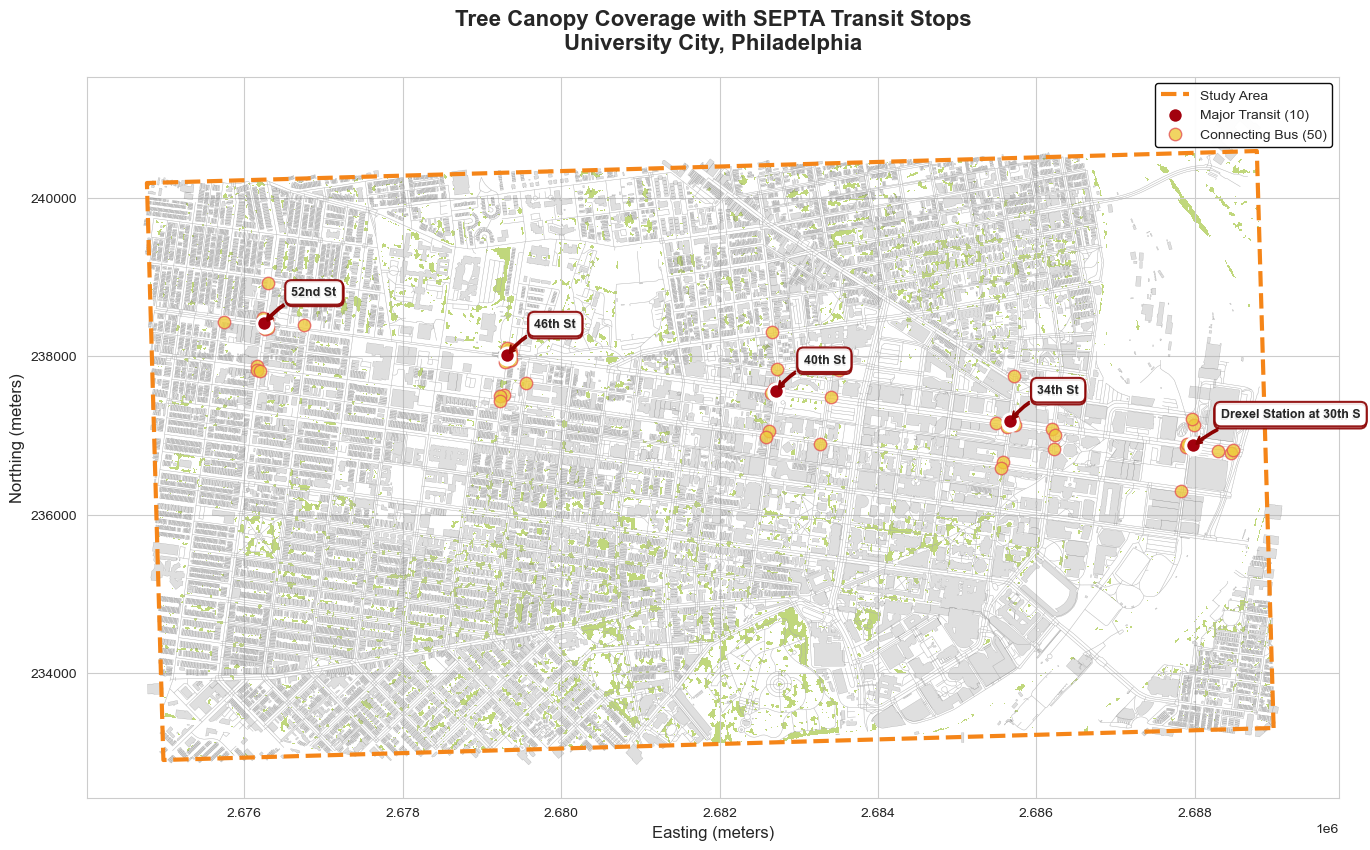

In [42]:
# Create overlay map with tree canopy and transit stops
with rasterio.open(tree_raster_path) as src:
    tree_canopy_mask = src.read(1)
    tree_display = np.ma.masked_where(tree_canopy_mask == 0, tree_canopy_mask)
    
    fig, ax = plt.subplots(figsize=(14, 14))
    
    # Show tree canopy with custom colors
    ax.imshow(
        tree_display,
        cmap=custom_greens,  # ✅ Now this variable exists
        alpha=1,
        vmin=0, vmax=1,
        extent=[src.bounds.left, src.bounds.right,
                src.bounds.bottom, src.bounds.top]
    )
    
    # Reproject to match raster CRS
    study_area_reproj = study_area.to_crs(src.crs)
    final_stops_reproj = final_stops.to_crs(src.crs)
    edges_gdf_reproj = edges_gdf.to_crs(src.crs)  # ✅ Added this
    buildings_reproj = buildings_filtered.to_crs(src.crs)  # ✅ Added this
    
    # Street network (using reprojected version)
    edges_gdf_reproj.plot(
        ax=ax, color='#B0B0B0', linewidth=0.3, 
        alpha=0.6, zorder=2
    )
    
    # Building footprints (using reprojected version)
    buildings_reproj.plot(
        ax=ax,
        facecolor='#B0B0B0',
        edgecolor='#404040',
        linewidth=0.2,
        alpha=0.4,
        label=f'Buildings ({len(buildings_filtered):,})',
        zorder=3
    )
    
    # Study area boundary
    study_area_reproj.boundary.plot(
        ax=ax, color='#f58518', linewidth=3,
        linestyle='--', label='Study Area', zorder=4
    )
    
    # Major transit stations
    major_plot = final_stops_reproj[final_stops_reproj['category'] == 'Major Transit']
    major_plot.plot(
        ax=ax, color='#A2010E', markersize=120, 
        marker='o', label=f'Major Transit ({len(major_plot)})', 
        edgecolor='white', linewidth=2,
        zorder=10
    )
    
    # Bus stops
    bus_plot = final_stops_reproj[final_stops_reproj['category'] == 'Feeder Bus']
    bus_plot.plot(
        ax=ax, color='#eeca3b', markersize=80, 
        marker='o', edgecolor='#e45756', linewidth=1,
        label=f'Connecting Bus ({len(bus_plot)})', 
        alpha=0.8, zorder=9
    )
    
    # Labels for major stations
    for idx, row in major_plot.iterrows():
        ax.annotate(
            row['name'],
            xy=(row.geometry.x, row.geometry.y),
            xytext=(20, 20),
            textcoords='offset points',
            fontsize=9,
            fontweight='bold',
            bbox=dict(
                boxstyle='round,pad=0.5', 
                facecolor='white',
                edgecolor='darkred', 
                linewidth=1.5, 
                alpha=0.9
            ),
            arrowprops=dict(
                arrowstyle='->',
                connectionstyle='arc3,rad=0.2',
                color='darkred',
                linewidth=1.5
            ),
            zorder=11
        )
    
    ax.set_title(
        'Tree Canopy Coverage with SEPTA Transit Stops\nUniversity City, Philadelphia',
        fontsize=16, fontweight='bold', pad=20
    )
    ax.set_xlabel('Easting (meters)', fontsize=12)
    ax.set_ylabel('Northing (meters)', fontsize=12)
    ax.legend(fontsize=10, loc='upper right', bbox_to_anchor=(1.0, 1.0),
              framealpha=0.95, edgecolor='black')
    
    # Set equal aspect ratio
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('outputs/maps/06_tree_canopy_with_transit.png', dpi=300, bbox_inches='tight')
    plt.show()


## Summary: Data Acquisition Complete

In [29]:
# Final status check

# Check all required files
data_status = {
    'Study Area': os.path.exists('data/processed/study_area.geojson'),
    'Pedestrian Network (GraphML)': os.path.exists('data/processed/university_city_walk_network.graphml'),
    'Network Nodes (GeoJSON)': os.path.exists('data/processed/network_nodes.geojson'),
    'Network Edges (GeoJSON)': os.path.exists('data/processed/network_edges.geojson'),
    'SEPTA Stops': os.path.exists('data/processed/septa_stops.geojson'),
    'Buildings': os.path.exists('data/processed/buildings_university_city.geojson'),
    'Tree Canopy Raster': os.path.exists('data/processed/tree_canopy_university_city.tif'),
}

print("\nData Files Status:")
for data_name, exists in data_status.items():
    status = "✓" if exists else "⚠"
    status_text = "Ready" if exists else "Missing"
    print(f"  {status} {data_name:.<55} {status_text}")

complete = sum(data_status.values())
total = len(data_status)

print("\nMaps Created:")
map_files = [
    '01_study_area.png',
    '02_network.png',
    '03_septa_stops.png',
    '04_buildings.png',
    '05_tree_canopy.png',
    '06_tree_canopy_with_transit.png'
]

for f in map_files:
    full_path = f'outputs/maps/{f}'
    if os.path.exists(full_path):
        print(f"  ✓ {f}")
    else:
        print(f"  ⚠ {f} - not created")


Data Files Status:
  ✓ Study Area............................................. Ready
  ✓ Pedestrian Network (GraphML)........................... Ready
  ✓ Network Nodes (GeoJSON)................................ Ready
  ✓ Network Edges (GeoJSON)................................ Ready
  ✓ SEPTA Stops............................................ Ready
  ✓ Buildings.............................................. Ready
  ✓ Tree Canopy Raster..................................... Ready

Maps Created:
  ✓ 01_study_area.png
  ✓ 02_network.png
  ✓ 03_septa_stops.png
  ✓ 04_buildings.png
  ✓ 05_tree_canopy.png
  ✓ 06_tree_canopy_with_transit.png
